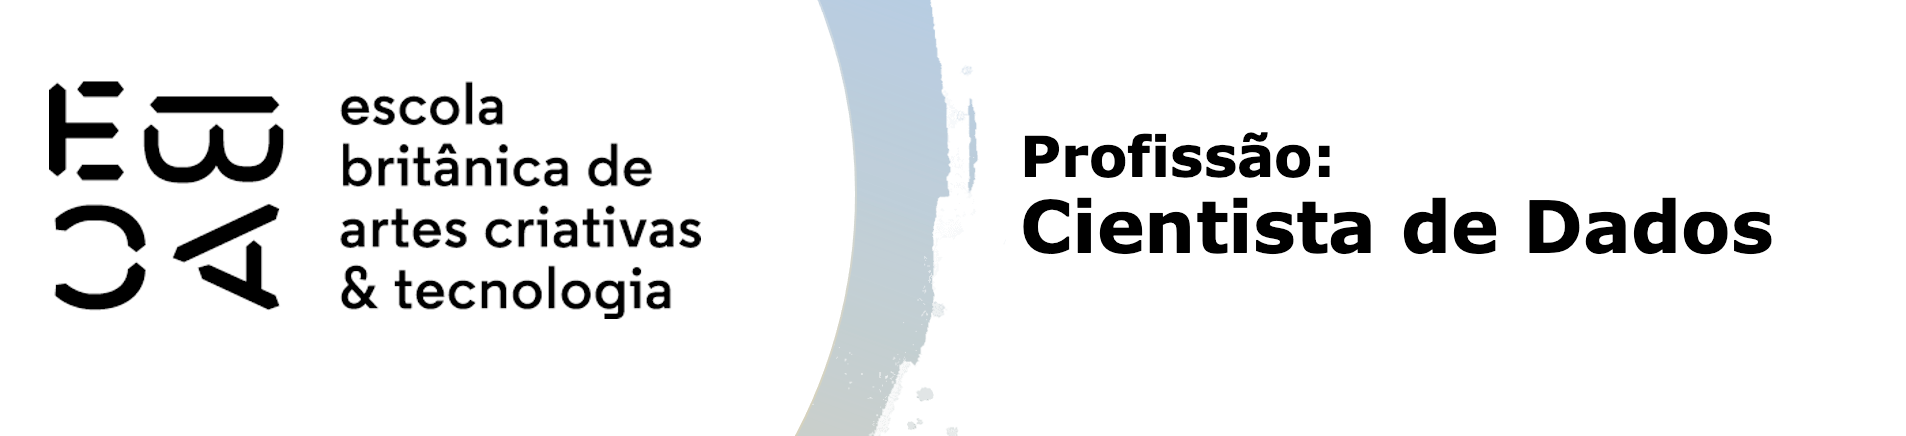

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_pickle('base_nfp.pkl')
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


In [3]:
df.shape

(187646, 13)

In [4]:
df.columns

Index(['CNPJ emit.', 'Emitente', 'No.', 'Data Emissão', 'Valor NF',
       'Data Registro', 'Créditos', 'Situação do Crédito', 'Ano', 'Semestre',
       'Retorno', 'flag_credito', 'categoria'],
      dtype='object')

In [5]:
df.dtypes

CNPJ emit.                     object
Emitente                       object
No.                             int64
Data Emissão           datetime64[ns]
Valor NF                      float64
Data Registro          datetime64[ns]
Créditos                      float64
Situação do Crédito          category
Ano                             int64
Semestre                        int64
Retorno                       float64
flag_credito                    int64
categoria                      object
dtype: object

## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [6]:
df['Mês'] = df['Data Emissão'].dt.month
dias_ptbr = {'Sunday' : 'Domingo', 'Monday':'Segunda-feira', 'Tuesday':'Terça-feira', 
            'Wednesday': 'Quarta-feira', 'Thursday':'Quinta-feira', 'Friday': 'Sexta-feira', 
            'Saturday' : 'Sábado'}
df['Dia da semana'] = df['Data Emissão'].dt.day_name().replace(dias_ptbr)
df.loc[(df['Dia da semana']=='Domingo')|(df['Dia da semana']=='Sábado'), 'fim de semana']=1
df.loc[(df['Dia da semana']=='Segunda-feira')|(df['Dia da semana']=='Terça-feira')|
       (df['Dia da semana']=='Quarta-feira')|(df['Dia da semana']=='Quinta-feira')|
       (df['Dia da semana']=='Sexta-feira'),
       'fim de semana']=0
df['fim de semana'] = df['fim de semana'].astype('int')
df['Trimestre'] = df['Data Emissão'].dt.quarter
df['dia'] = df['Data Emissão'].dt.day
df['Vlr_NF_q5'] = pd.qcut(df['Valor NF'], q=5, labels = list(range(5)))
df['Vlr_NF_q10'] = pd.qcut(df['Valor NF'], q=10, labels = list(range(10)))
df['Vlr_NF_q20'] = pd.qcut(df['Valor NF'], q=20, labels = list(range(20)))
df['Vlr_NF_q50'] = pd.qcut(df['Valor NF'], q=50, labels = list(range(50)))
df = df[['CNPJ emit.','Emitente','No.', 'Data Emissão','Valor NF','Vlr_NF_q5','Vlr_NF_q10', 'Vlr_NF_q20', 'Vlr_NF_q50',
         'Data Registro','Créditos', 'Situação do Crédito','Ano', 'Mês', 'dia', 'Semestre', 'Trimestre',
         'Dia da semana', 'fim de semana', 'Retorno', 'flag_credito', 'categoria']]


In [7]:
df.dtypes

CNPJ emit.                     object
Emitente                       object
No.                             int64
Data Emissão           datetime64[ns]
Valor NF                      float64
Vlr_NF_q5                    category
Vlr_NF_q10                   category
Vlr_NF_q20                   category
Vlr_NF_q50                   category
Data Registro          datetime64[ns]
Créditos                      float64
Situação do Crédito          category
Ano                             int64
Mês                             int64
dia                             int64
Semestre                        int64
Trimestre                       int64
Dia da semana                  object
fim de semana                   int64
Retorno                       float64
flag_credito                    int64
categoria                      object
dtype: object

In [8]:
df.head(5)

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Vlr_NF_q5,Vlr_NF_q10,Vlr_NF_q20,Vlr_NF_q50,Data Registro,...,Ano,Mês,dia,Semestre,Trimestre,Dia da semana,fim de semana,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,1,3,7,17,2017-06-30,...,2017,6,30,1,2,Sexta-feira,0,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2,5,11,28,2017-06-30,...,2017,6,30,1,2,Sexta-feira,0,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,1,3,7,19,2017-06-30,...,2017,6,30,1,2,Sexta-feira,0,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,3,7,15,38,2017-06-30,...,2017,6,30,1,2,Sexta-feira,0,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,3,7,15,39,2017-06-30,...,2017,6,30,1,2,Sexta-feira,0,0.016240,1,Restaurantes


## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [9]:
metadados = pd.DataFrame({'dtypes':df.dtypes}) # construindo metadados
metadados['papel'] = 'covariavel' # atribuindo papel
metadados.loc['flag_credito', 'papel'] = 'resposta'
metadados['nunique'] = df.nunique() # elementos distintos em cada covariavel 
metadados

,dtypes,papel,nunique
CNPJ emit.,object,covariavel,19606
Emitente,object,covariavel,15575
No.,int64,covariavel,124400
Data Emissão,datetime64[ns],covariavel,1815
Valor NF,float64,covariavel,33658
Vlr_NF_q5,category,covariavel,5
Vlr_NF_q10,category,covariavel,10
Vlr_NF_q20,category,covariavel,20
Vlr_NF_q50,category,covariavel,50
Data Registro,datetime64[ns],covariavel,1817


In [10]:
# construção de uma função

def InformationValue(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name = 'total')
    rótulo_evento = tab.columns[0]
    rótulo_não_evento = tab.columns[1]
    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total', rótulo_evento]
    tab['pct_não_evento'] = tab[rótulo_não_evento]/tab.loc['total', rótulo_não_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_não_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_não_evento)*tab.woe
    return tab['iv_parcial'].sum()

InformationValue(df.Vlr_NF_q5 ,df.flag_credito)

0.056694656985935774

In [11]:
for var in metadados[metadados.papel=='covariavel'].index:
    metadados.loc[var, 'IV'] = InformationValue(df[var], df.flag_credito)

metadados

/opt/anaconda/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  r

,dtypes,papel,nunique,IV
CNPJ emit.,object,covariavel,19606,inf
Emitente,object,covariavel,15575,inf
No.,int64,covariavel,124400,inf
Data Emissão,datetime64[ns],covariavel,1815,inf
Valor NF,float64,covariavel,33658,inf
Vlr_NF_q5,category,covariavel,5,0.056695
Vlr_NF_q10,category,covariavel,10,0.106650
Vlr_NF_q20,category,covariavel,20,0.124525
Vlr_NF_q50,category,covariavel,50,0.152315
Data Registro,datetime64[ns],covariavel,1817,inf


## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

<font color='blue'>Segundo a regra de bolso de Naeem Siddiqi para interpretar o IV (Inútil de 0 a 0,02; Fraco de 0,02 a 0,1; Médio de 0,1 a 0,3; Forte de 0,3 a 0,5; e Suspeito de tão alto de 0,5 ou mais), a variável que apresenta maior poder de discriminação segundo Information Value (IV) é a variável 'categoria' (Forte), seguido das variáveis Vlr_NF_q50 (médio), Vlr_NF_q20 (médio), Vlr_NF_q20 (médio), Vlr_NF_q10 (médio), Vlr_NF_q5 (fraco).</font>

<font color='blue'> Sim, quando categorizamos as variáveis contínuas parece haver alguma relação entre o número de categorias e o IV, note-se que quanto maior o número de categorização maior é o IV (ou seja, melhora o poder preditivo da variável.</font>


## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

In [12]:
df1=pd.get_dummies(df['flag_credito'], drop_first=False)
df1.rename(columns={0:'sem_credito', 1:'com_credito'}, inplace=True)
df2 = pd.concat([df[['Ano', 'Trimestre', 'categoria']], df1], axis=1)
df2['total']=df2.sem_credito + df2.com_credito
df2['Ano_Trimestre'] = df2['Ano'].astype(str) + '_' + df2['Trimestre'].astype(str)
df2.drop(['Ano', 'Trimestre'], axis=1)
df2

tab_total = pd.pivot_table(df2, values='total', index=['categoria'],
              columns=['Ano_Trimestre'], aggfunc=np.sum, margins=True, margins_name='subtotal')

tab_t1=tab_total.T
tab_t1=tab_t1.drop(['subtotal'], axis=1)
tab_t1=tab_t1.drop(['subtotal'], axis=0)
tab_t1 = pd.DataFrame(tab_t1.stack().reset_index())
tab_t1.rename(columns={0:'Total de NFs'}, inplace=True)


tab_cred = pd.pivot_table(df2, values='com_credito', index=['categoria', ],
              columns=['Ano_Trimestre'], aggfunc=np.sum, margins=True, margins_name='subtotal')


tab_pct = tab_cred/tab_total
tab_pct=tab_pct.T
tab_pct = tab_pct.drop(['subtotal'], axis=1)
tab_pct = tab_pct.drop(['subtotal'], axis=0)
tab_pct = pd.DataFrame(tab_pct.stack().reset_index())
tab_pct.rename(columns={0:'Pct_crédito'}, inplace=True)
print(tab_pct.shape)
print(tab_pct.columns)


(180, 3)
Index(['Ano_Trimestre', 'categoria', 'Pct_crédito'], dtype='object')


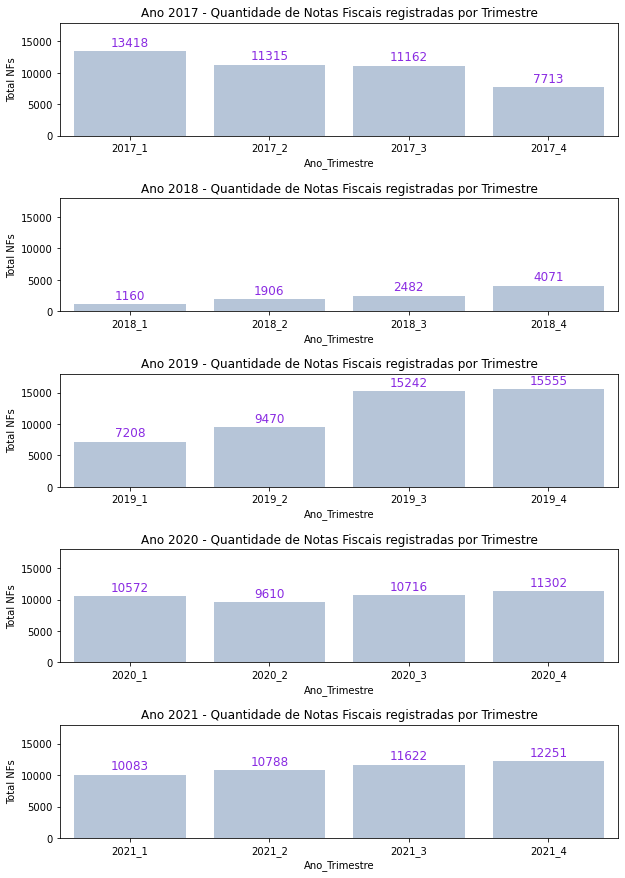

In [14]:
# Quantidade de Notas Fiscais registradas na base por período

tab_tt = tab_total.T
tab_tt = tab_tt.drop(['subtotal'], axis=0)
tab_tt = tab_tt.reset_index()
tab_tt

plt.rc('figure', figsize=(10,15))
fig, axes = plt.subplots(5)

ax = axes[0]
plot=sns.barplot(ax = axes[0], x='Ano_Trimestre', y='subtotal', data = tab_tt[0:4], color= 'lightsteelblue')
for i in plot.patches:
    plot.annotate(int(i.get_height()),
                 (i.get_x()+i.get_width()/2, i.get_height()),
                 ha='center', va='baseline', fontsize=12, color = 'blueviolet',
                 xytext=(0,5), textcoords = 'offset points')
ax.set_title('Ano 2017 - Quantidade de Notas Fiscais registradas por Trimestre')
ax.set_ylabel('Total NFs')
ax.set_ylim(ymax=18000)

ax = axes[1]
plot=sns.barplot(ax = axes[1], x='Ano_Trimestre', y='subtotal', data = tab_tt[4:8], color= 'lightsteelblue')
for i in plot.patches:
    plot.annotate(int(i.get_height()),
                 (i.get_x()+i.get_width()/2, i.get_height()),
                 ha='center', va='baseline', fontsize=12, color = 'blueviolet',
                 xytext=(0,5), textcoords = 'offset points')
ax.set_title('Ano 2018 - Quantidade de Notas Fiscais registradas por Trimestre')
ax.set_ylabel('Total NFs')
ax.set_ylim(ymax=18000)

ax = axes[2]
plot=sns.barplot(ax = axes[2], x='Ano_Trimestre', y='subtotal', data = tab_tt[8:12], color= 'lightsteelblue')
for i in plot.patches:
    plot.annotate(int(i.get_height()),
                 (i.get_x()+i.get_width()/2, i.get_height()),
                 ha='center', va='baseline', fontsize=12, color = 'blueviolet',
                 xytext=(0,5), textcoords = 'offset points')
ax.set_title('Ano 2019 - Quantidade de Notas Fiscais registradas por Trimestre')
ax.set_ylabel('Total NFs')
ax.set_ylim(ymax=18000)

ax = axes[3]
plot=sns.barplot(ax = axes[3], x='Ano_Trimestre', y='subtotal', data = tab_tt[12:16], color= 'lightsteelblue')
for i in plot.patches:
    plot.annotate(int(i.get_height()),
                 (i.get_x()+i.get_width()/2, i.get_height()),
                 ha='center', va='baseline', fontsize=12, color = 'blueviolet',
                 xytext=(0,5), textcoords = 'offset points')
ax.set_title('Ano 2020 - Quantidade de Notas Fiscais registradas por Trimestre')
ax.set_ylabel('Total NFs')
ax.set_ylim(ymax=18000)

ax = axes[4]
plot=sns.barplot(ax = axes[4], x='Ano_Trimestre', y='subtotal', data = tab_tt[16:20], color= 'lightsteelblue')
for i in plot.patches:
    plot.annotate(int(i.get_height()),
                 (i.get_x()+i.get_width()/2, i.get_height()),
                 ha='center', va='baseline', fontsize=12, color = 'blueviolet',
                 xytext=(0,5), textcoords = 'offset points')
ax.set_title('Ano 2021 - Quantidade de Notas Fiscais registradas por Trimestre')
ax.set_ylabel('Total NFs')
ax.set_ylim(ymax=18000)

plt.subplots_adjust(hspace=0.55)
plt.show();


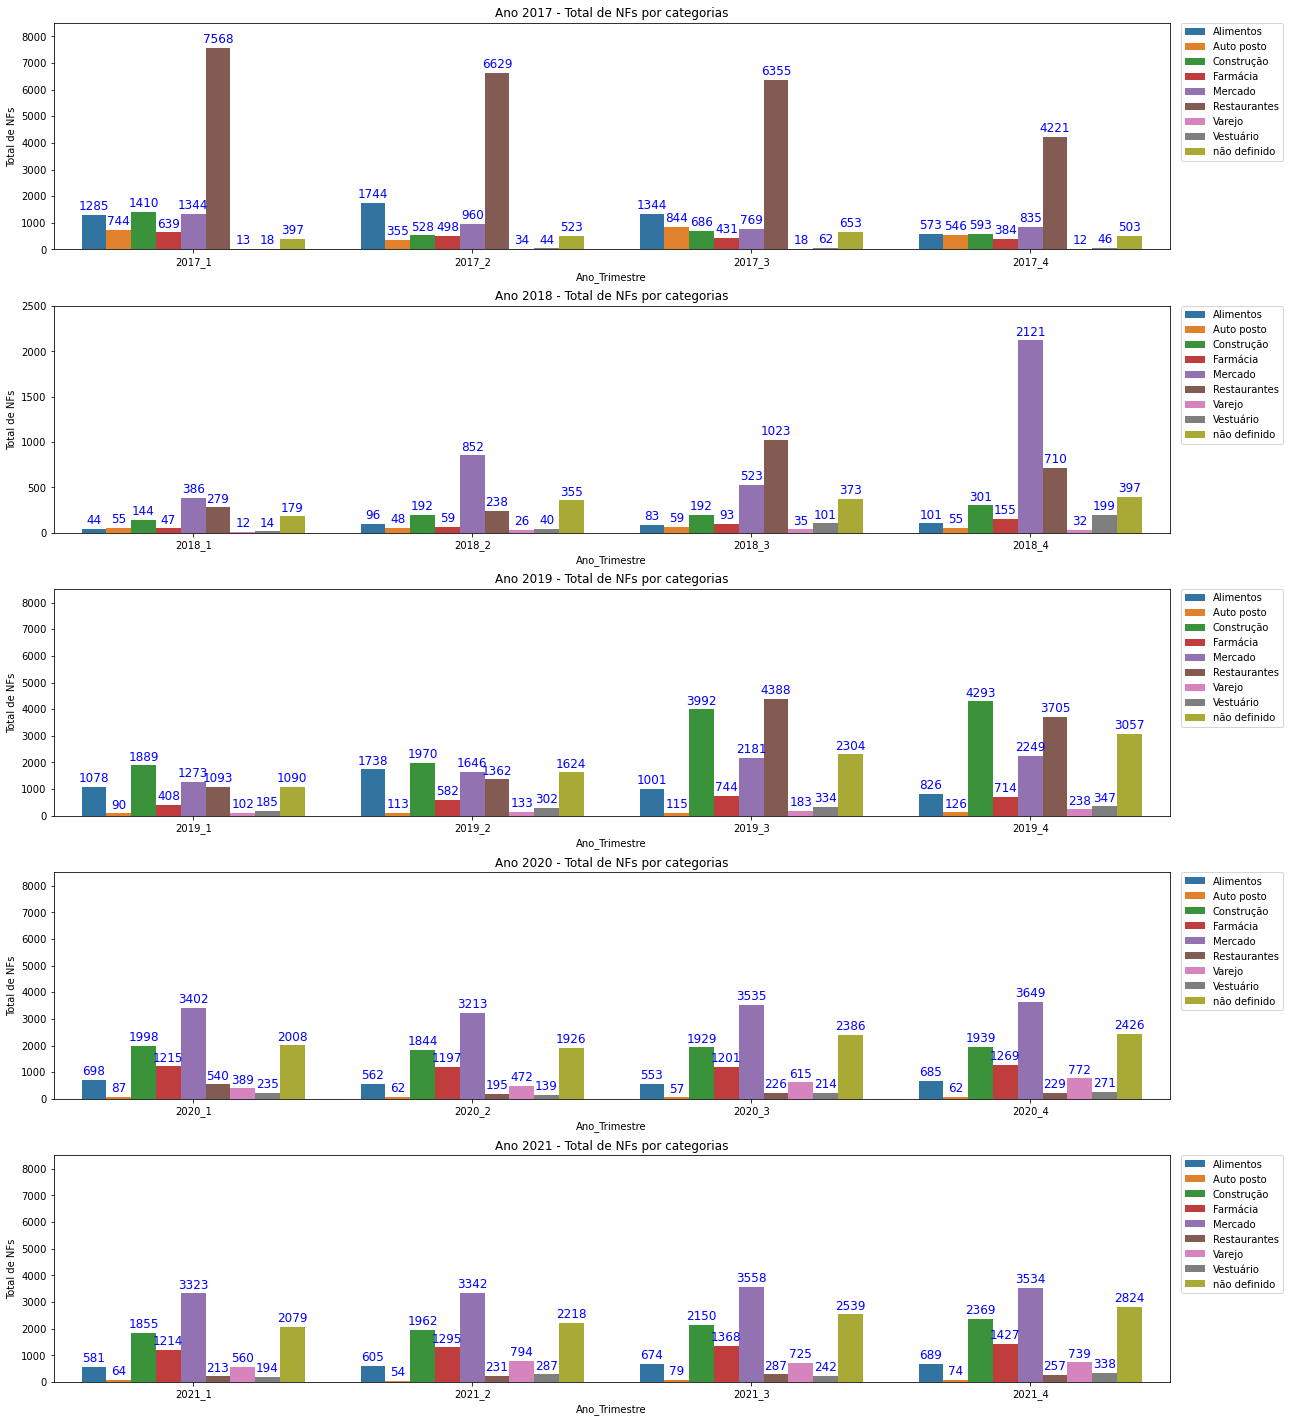

In [15]:
# Quantidade de Notas por categoria e por período

plt.rc('figure', figsize=(20,25))
fig, axes= plt.subplots(5)

ax = axes[0]
plot = sns.barplot(ax=axes[0], x='Ano_Trimestre', y = 'Total de NFs', hue='categoria', data=tab_t1[0:36])
for i in plot.patches:
    plot.annotate(int(i.get_height()),
                 (i.get_x()+i.get_width()/2, i.get_height()),
                  ha = 'center', va = 'baseline', fontsize = 12, color='blue', 
                  xytext = (0,5), textcoords = 'offset points')
ax.set_title('Ano 2017 - Total de NFs por categorias')
ax.set_ylim(ymax = 8500)
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0)

ax = axes[1]
plot = sns.barplot(ax=axes[1], x='Ano_Trimestre', y = 'Total de NFs', hue='categoria', data=tab_t1[36:72])
for i in plot.patches:
    plot.annotate(int(i.get_height()),
                 (i.get_x()+i.get_width()/2, i.get_height()),
                  ha = 'center', va = 'baseline', fontsize = 12, color='blue', 
                  xytext = (0,5), textcoords = 'offset points')
ax.set_title('Ano 2018 - Total de NFs por categorias')
ax.set_ylim(ymax = 2500)
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0)

ax = axes[2]
plot = sns.barplot(ax=axes[2], x='Ano_Trimestre', y = 'Total de NFs', hue='categoria', data=tab_t1[72:108])
for i in plot.patches:
    plot.annotate(int(i.get_height()),
                 (i.get_x()+i.get_width()/2, i.get_height()),
                  ha = 'center', va = 'baseline', fontsize = 12, color='blue', 
                  xytext = (0,5), textcoords = 'offset points')
ax.set_title('Ano 2019 - Total de NFs por categorias')
ax.set_ylim(ymax = 8500)
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0)

ax = axes[3]
plot = sns.barplot(ax=axes[3], x='Ano_Trimestre', y = 'Total de NFs', hue='categoria', data=tab_t1[108:144])
for i in plot.patches:
    plot.annotate(int(i.get_height()),
                 (i.get_x()+i.get_width()/2, i.get_height()),
                  ha = 'center', va = 'baseline', fontsize = 12, color='blue', 
                  xytext = (0,5), textcoords = 'offset points')
ax.set_title('Ano 2020 - Total de NFs por categorias')
ax.set_ylim(ymax = 8500)
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0)


ax = axes[4]
plot = sns.barplot(ax=axes[4], x='Ano_Trimestre', y = 'Total de NFs', hue='categoria', data=tab_t1[144:180])
for i in plot.patches:
    plot.annotate(int(i.get_height()),
                 (i.get_x()+i.get_width()/2, i.get_height()),
                  ha = 'center', va = 'baseline', fontsize = 12, color='blue', 
                  xytext = (0,5), textcoords = 'offset points')
ax.set_title('Ano 2021 - Total de NFs por categorias')
ax.set_ylim(ymax = 8500)
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0)


plt.subplots_adjust(hspace=0.25)
plt.show();

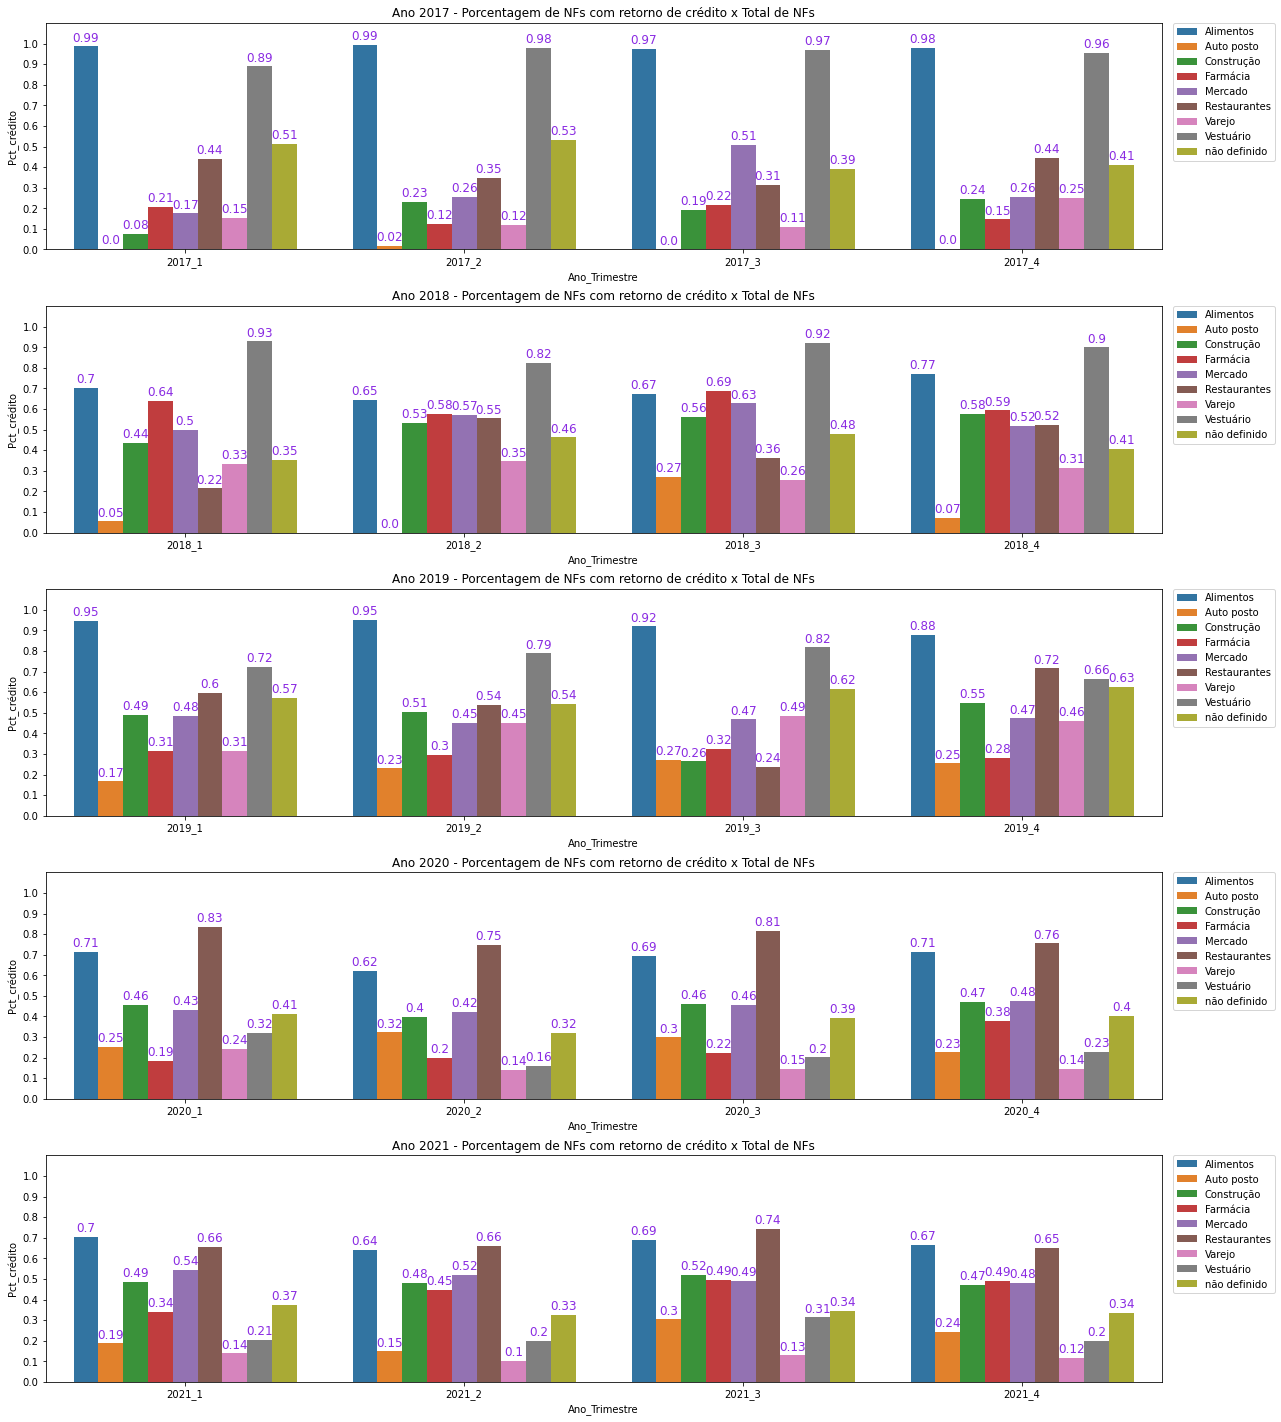

In [16]:
# Proporção de notas com crédito por categoria por período

plt.rc('figure', figsize=(20,25))
fig, axes=plt.subplots(5)

ax=axes[0]
plot= sns.barplot(ax=axes[0],data=tab_pct[0:36], x= 'Ano_Trimestre', y='Pct_crédito', hue='categoria')
for i in plot.patches:
    plot.annotate(round(float(i.get_height()),2),
                  (i.get_x()+i.get_width()/2, i.get_height()),
                  ha='center', va='baseline', fontsize = 12, color = 'blueviolet',
                  xytext=(0, 5), textcoords = 'offset points')
ax.set_title('Ano 2017 - Porcentagem de NFs com retorno de crédito x Total de NFs')
ax.set_yticks([0.1*i for i in range(11)])
ax.set_ylim(ymax=1.1)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

ax=axes[1]
plot= sns.barplot(ax=axes[1],data=tab_pct[36:72], x= 'Ano_Trimestre', y='Pct_crédito', hue='categoria')
for i in plot.patches:
    plot.annotate(round(float(i.get_height()),2),
                  (i.get_x()+i.get_width()/2, i.get_height()),
                  ha='center', va='baseline', fontsize = 12, color = 'blueviolet',
                  xytext=(0, 5), textcoords = 'offset points')
ax.set_title('Ano 2018 - Porcentagem de NFs com retorno de crédito x Total de NFs')
ax.set_yticks([0.1*i for i in range(11)])
ax.set_ylim(ymax=1.1)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

ax=axes[2]
plot= sns.barplot(ax=axes[2],data=tab_pct[72:108], x= 'Ano_Trimestre', y='Pct_crédito', hue='categoria')
for i in plot.patches:
    plot.annotate(round(float(i.get_height()),2),
                  (i.get_x()+i.get_width()/2, i.get_height()),
                  ha='center', va='baseline', fontsize = 12, color = 'blueviolet',
                  xytext=(0, 5), textcoords = 'offset points')
ax.set_title('Ano 2019 - Porcentagem de NFs com retorno de crédito x Total de NFs')
ax.set_yticks([0.1*i for i in range(11)])
ax.set_ylim(ymax=1.1)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

ax=axes[3]
plot= sns.barplot(ax=axes[3],data=tab_pct[108:144], x= 'Ano_Trimestre', y='Pct_crédito', hue='categoria')
for i in plot.patches:
    plot.annotate(round(float(i.get_height()),2),
                  (i.get_x()+i.get_width()/2, i.get_height()),
                  ha='center', va='baseline', fontsize = 12, color = 'blueviolet',
                  xytext=(0, 5), textcoords = 'offset points')
ax.set_title('Ano 2020 - Porcentagem de NFs com retorno de crédito x Total de NFs')
ax.set_yticks([0.1*i for i in range(11)])
ax.set_ylim(ymax=1.1)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

ax=axes[4]
plot= sns.barplot(ax=axes[4],data=tab_pct[144:180], x= 'Ano_Trimestre', y='Pct_crédito', hue='categoria')
for i in plot.patches:
    plot.annotate(round(float(i.get_height()),2),
                  (i.get_x()+i.get_width()/2, i.get_height()),
                  ha='center', va='baseline', fontsize = 12, color = 'blueviolet',
                  xytext=(0, 5), textcoords = 'offset points')
ax.set_title('Ano 2021 - Porcentagem de NFs com retorno de crédito x Total de NFs')
ax.set_yticks([0.1*i for i in range(11)])
ax.set_ylim(ymax=1.1)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

plt.subplots_adjust(hspace=0.25)
plt.show();

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [17]:
df3 = df2.set_index(['Ano_Trimestre', 'categoria'])
df3 = df3.drop(['Ano', 'Trimestre'], axis=1)
df4 = pd.DataFrame(df3.groupby(['Ano_Trimestre', 'categoria'])['com_credito'].sum())
df5 = pd.DataFrame(df3.groupby(['Ano_Trimestre', 'categoria'])['sem_credito'].sum())
df6 = pd.concat([df4, df5],axis=1)
df6['total_NFs'] = df6['com_credito']+df6['sem_credito']
df6['tx_evento'] = df6['com_credito']/df6['total_NFs']
df6['pct_evento'] = df6['com_credito']/df6['com_credito'].groupby(level=0).sum() # o evento é a condição 'com_crédito'
df6['pct_nao_evento'] = df6['sem_credito']/df6['sem_credito'].groupby(level=0).sum()
df6['WOE'] = np.log(df6.pct_evento/df6.pct_nao_evento)
df6['IV'] = ((df6.pct_evento - df6.pct_nao_evento)*df6.WOE)


/opt/anaconda/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


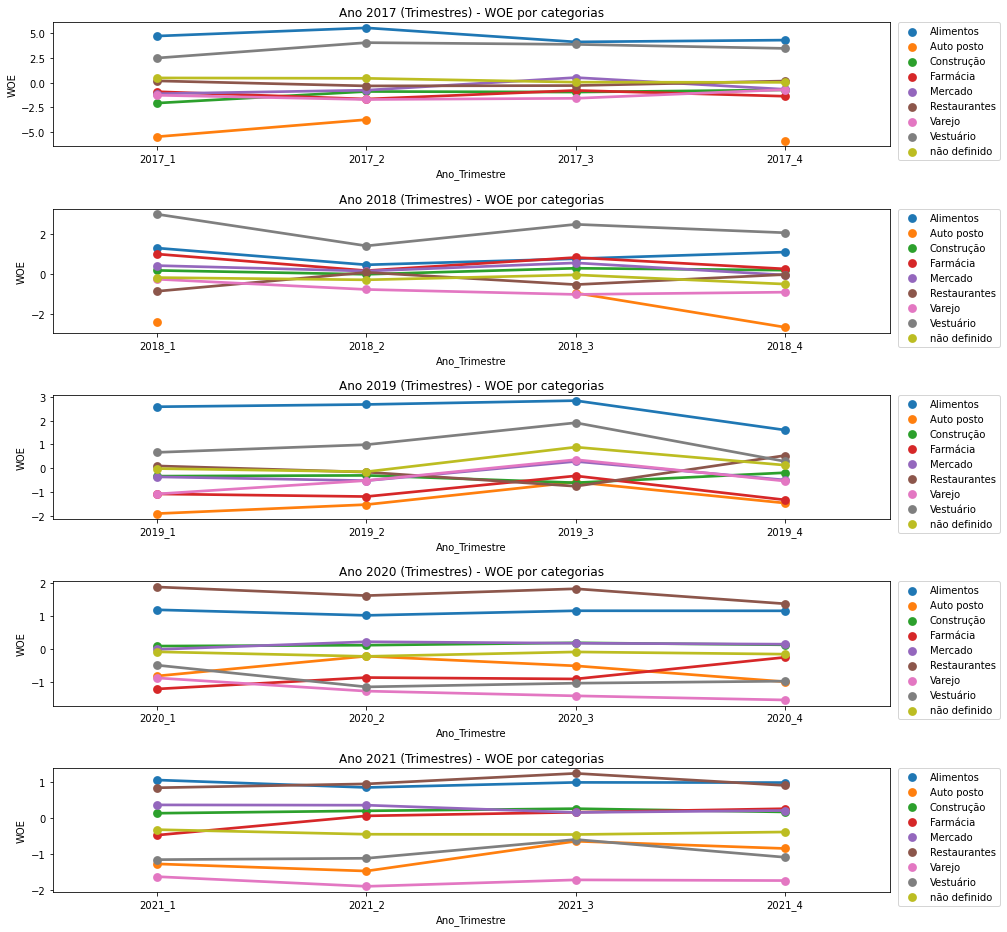

In [18]:
plt.rc('figure', figsize=(15,16))
fig, (ax1, ax2, ax3, ax4, ax5)= plt.subplots(5)

sns.pointplot(ax=ax1, data=df6[0:36].reset_index(), x='Ano_Trimestre', y='WOE', hue='categoria')
ax1.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
ax1.set_title('Ano 2017 (Trimestres) - WOE por categorias')

sns.pointplot(ax=ax2, data=df6[36:72].reset_index(), x='Ano_Trimestre', y='WOE', hue='categoria')
ax2.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
ax2.set_title('Ano 2018 (Trimestres) - WOE por categorias')

sns.pointplot(ax=ax3, data=df6[72:108].reset_index(), x='Ano_Trimestre', y='WOE', hue='categoria')
ax3.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
ax3.set_title('Ano 2019 (Trimestres) - WOE por categorias')

sns.pointplot(ax=ax4, data=df6[108:144].reset_index(), x='Ano_Trimestre', y='WOE', hue='categoria')
ax4.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
ax4.set_title('Ano 2020 (Trimestres) - WOE por categorias')

sns.pointplot(ax=ax5, data=df6[144:180].reset_index(), x='Ano_Trimestre', y='WOE', hue='categoria')
ax5.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
ax5.set_title('Ano 2021 (Trimestres) - WOE por categorias')

plt.subplots_adjust(hspace=0.5)
plt.show();

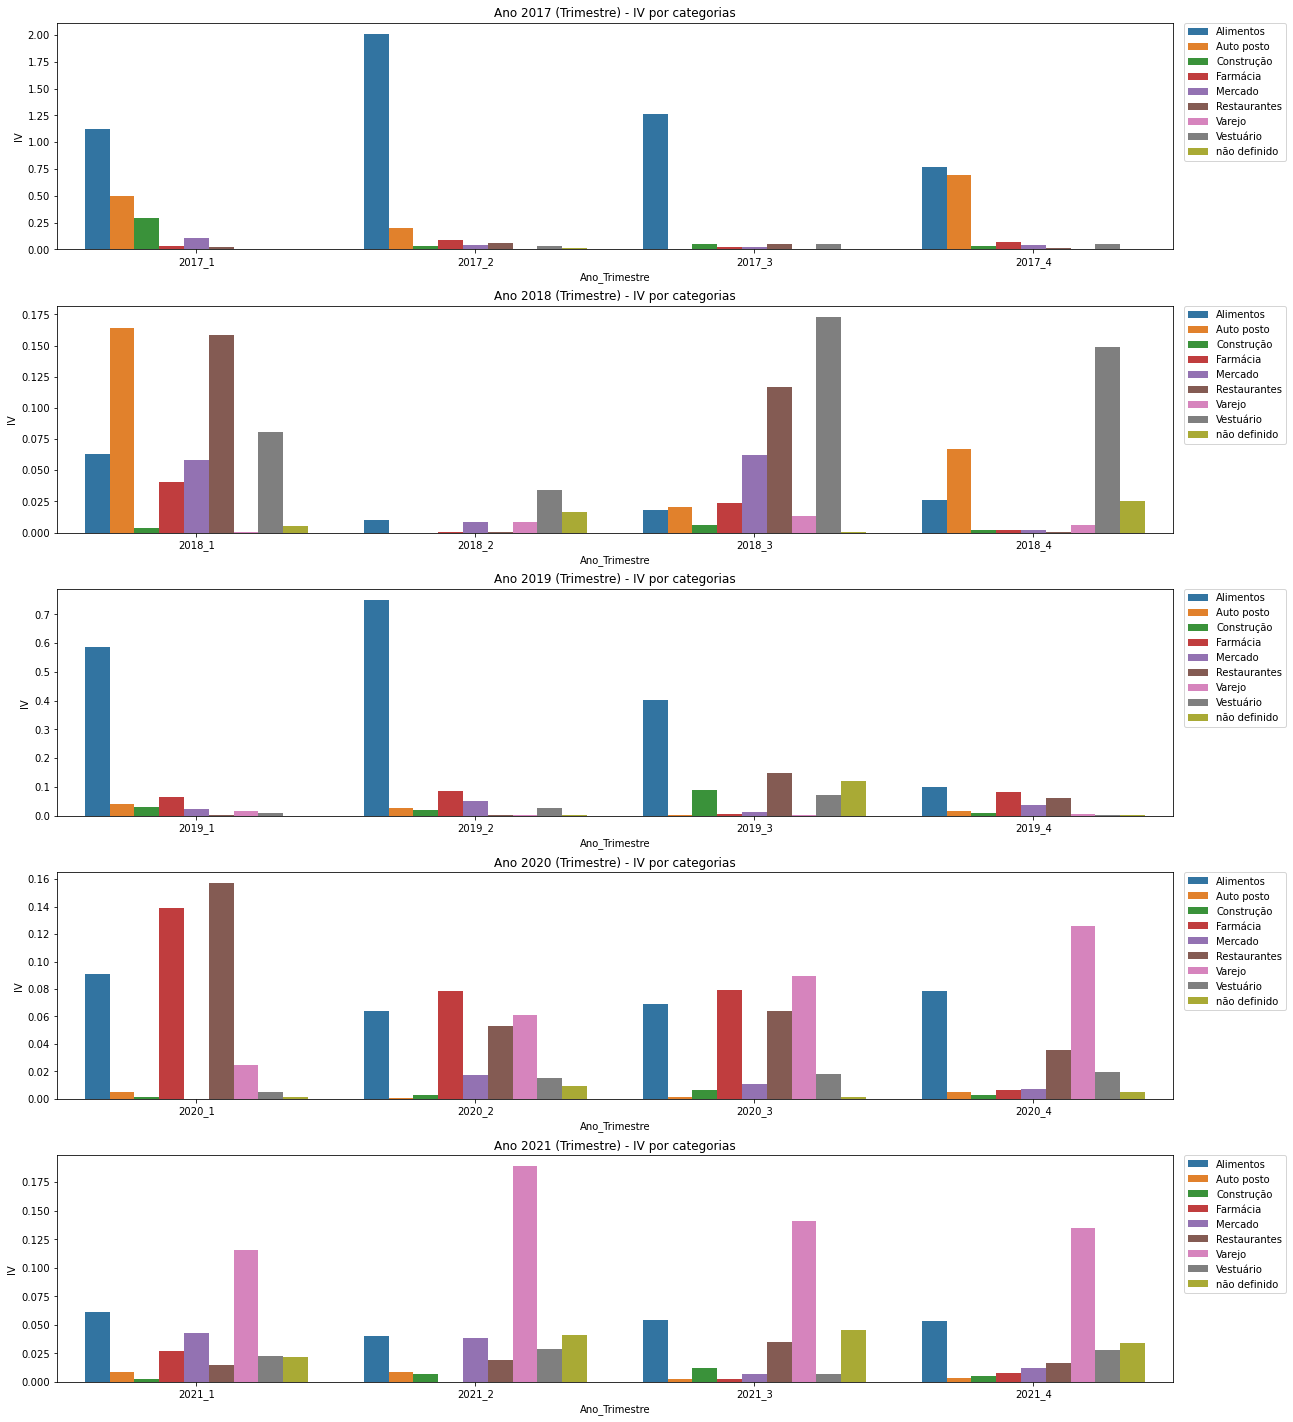

In [19]:
plt.rc('figure', figsize=(20,25))
fig, axes=plt.subplots(5)

ax=axes[0]
sns.barplot(ax=axes[0],data=df6[0:36].reset_index(), x= 'Ano_Trimestre', y='IV', hue='categoria')
ax.set_title('Ano 2017 (Trimestre) - IV por categorias')
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

ax=axes[1]
plot= sns.barplot(ax=axes[1],data=df6[36:72].reset_index(), x= 'Ano_Trimestre', y='IV', hue='categoria')
ax.set_title('Ano 2018 (Trimestre) - IV por categorias')
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

ax=axes[2]
plot= sns.barplot(ax=axes[2],data=df6[72:108].reset_index(), x= 'Ano_Trimestre', y='IV', hue='categoria')
ax.set_title('Ano 2019 (Trimestre) - IV por categorias')
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

ax=axes[3]
plot= sns.barplot(ax=axes[3],data=df6[108:144].reset_index(), x= 'Ano_Trimestre', y='IV', hue='categoria')
ax.set_title('Ano 2020 (Trimestre) - IV por categorias')
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

ax=axes[4]
plot= sns.barplot(ax=axes[4],data=df6[144:180].reset_index(), x= 'Ano_Trimestre', y='IV', hue='categoria')
ax.set_title('Ano 2021 (Trimestre) - IV por categorias')
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

plt.subplots_adjust(hspace=0.25)
plt.show();

In [20]:
def plot_iv(df,hue):
    plt.rc('figure', figsize=(20,25))
    fig, ax = plt.subplots()
    sns.pointplot(ax=ax, data=df, x='Ano_Trimestre', y='IV', hue=hue)
    ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
    ax.set_title('Information Value por Categoria ao longo dos anos')
    a = [.02]*int(len(df.Ano_Trimestre))
    b = [.1]*int(len(df.Ano_Trimestre))
    c = [.3]*int(len(df.Ano_Trimestre))
    d = [.5]*int(len(df.Ano_Trimestre))
    e = [2.1]*int(len(df.Ano_Trimestre))
    ax.fill_between(df.Ano_Trimestre, a, color='grey', alpha=.2)
    ax.fill_between(df.Ano_Trimestre, a, b, color='orange', alpha=.1)
    ax.fill_between(df.Ano_Trimestre, b, c, color='green', alpha=.1)
    ax.fill_between(df.Ano_Trimestre, c, d, color='blue', alpha=.1)
    ax.fill_between(df.Ano_Trimestre, d, e, color='purple', alpha=.1)
    ax.set_ylabel("Information Value")
    ax.set_xlabel("Anos - Trimestres")
    ax.set_xticklabels(df.Ano_Trimestre.unique(), rotation=30, ha='center', fontsize='small')
    plt.show();

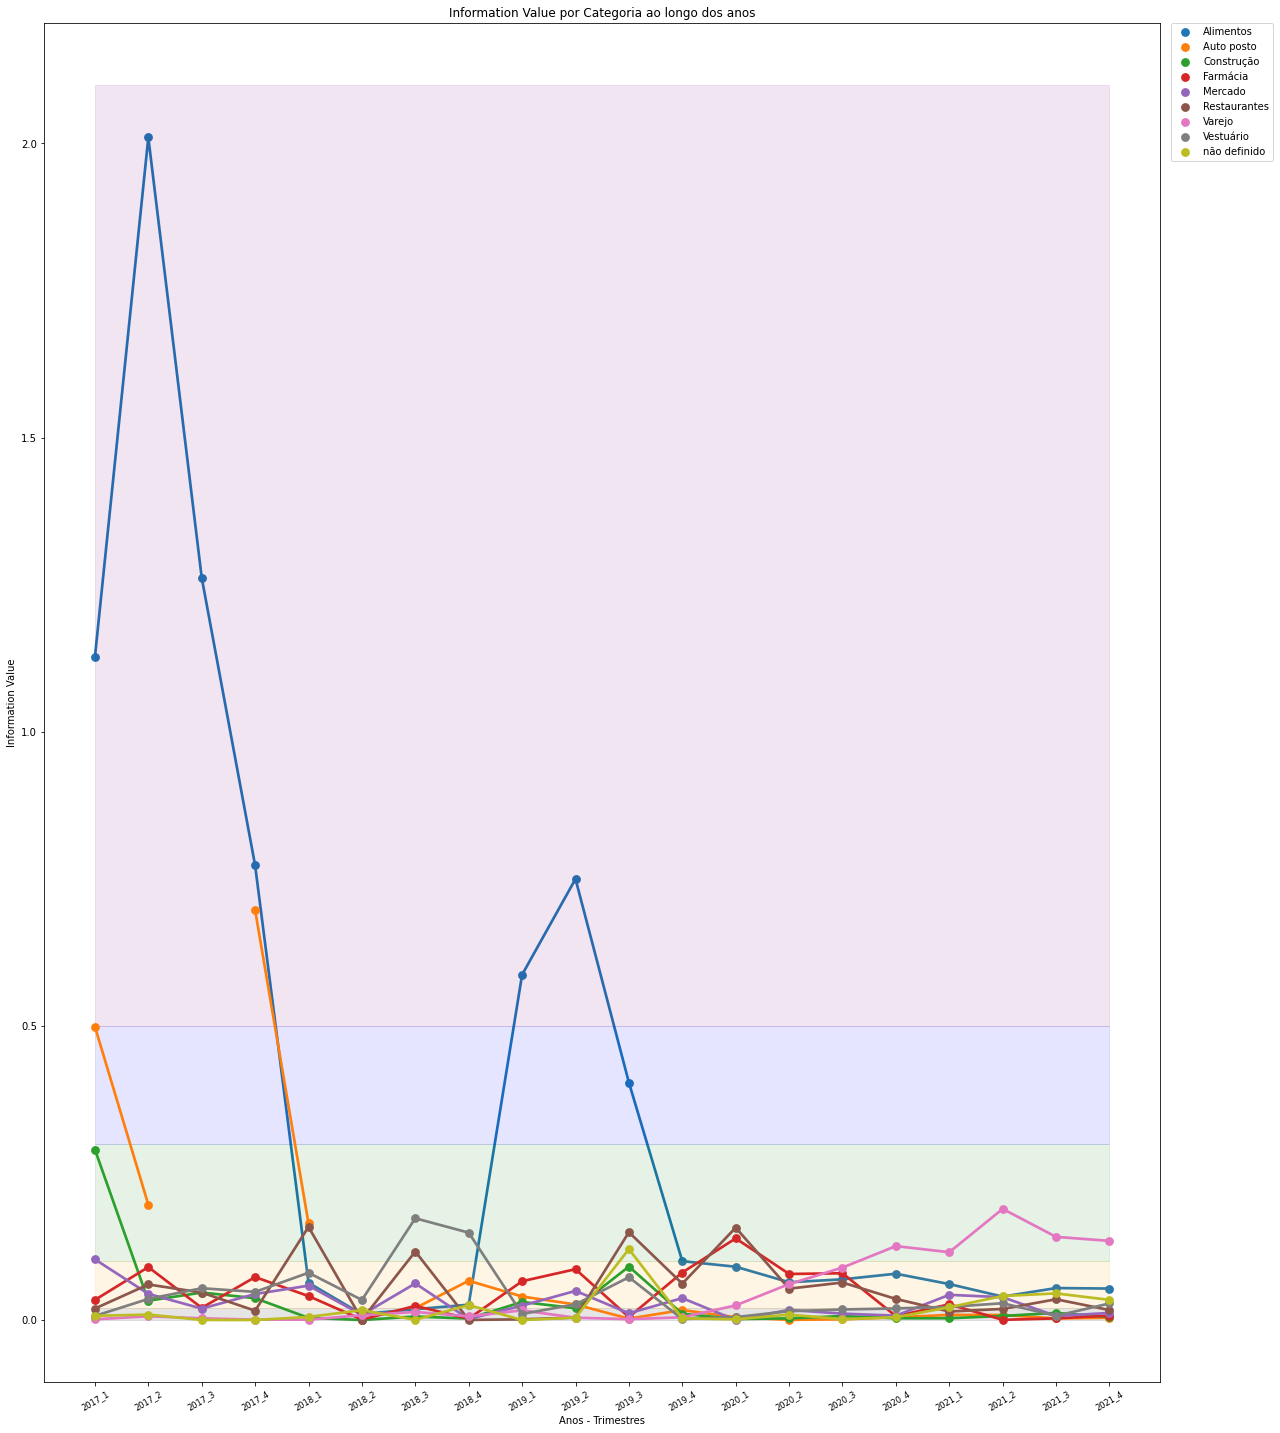

In [27]:
plot_iv(df6.reset_index(), 'categoria')

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

<font color='blue'>As categorias que tiveram maior proporção de notas com retornos maiores que zero foi Alimento e Vestuário nos anos de 2017, 2018 e 2019, a partir de 2020, inclusive 2021, passou a ser o setor de Restaurante e Alimento. Quanto a estabilidade no tempo, o que se percebe é que houve diminuição proporcional em todos os setores acerca do retorno de crédito, principalmente a partir do ano de 2020. Possivelmente, a diminuição teve seus fatores relacionados à crise econômica de 2018 (tanto é verdade que neste ano houve menor emissão de Notas Fiscais), bem como a Pandemia ocorrida em 2020. Verifica-se no gráfico de totalidade de Notas Fiscais emitidas que a partir de 2020, a emissão de Notas Fiscais começaram a ter um aumento gradativo. Nos anos de 2020 e 2021, os setores que emitiram maior número de Notas Fiscais foi o setor de Mercado, Construção e não definido, possivelmente reflexos da pandemia que obrigou os consumidores mudarem os seus hábitos. Contudo neste mesmo período, as notas fiscais com maior proporção de retorno de crédito foram dos setores de Restaurante e Alimentos (conforme inicialmente comentado).  Para 2023, espera-se a continuidade do aumento gradativo na emissão de Notas Fiscais, bem como aumento no setores de vestuário, Restaurante e Alimentos, em razão fim do confinamento da pandemia.</font>